In [3]:
import numpy as np
import pandas as pd
import squidpy as sq
import scanpy as sc

import matplotlib.pyplot as plt
simulated_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/simulated/simulated_Sample_data_151673.h5ad")
real_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/processed_151673_filtered.h5ad")

simulated_adata.obs_names_make_unique()
real_adata.obs_names_make_unique()
simulated_adata.var_names_make_unique()
real_adata.var_names_make_unique()
sc.pp.normalize_total(real_adata)
sc.pp.log1p(real_adata)
sc.pp.normalize_total(simulated_adata)
sc.pp.log1p(simulated_adata)


#计算highly variable genes
sc.pp.highly_variable_genes(real_adata, n_top_genes=2000)
sc.pp.highly_variable_genes(simulated_adata, n_top_genes=2000)

# 获取真实数据和模拟数据中的高度可变基因集
real_hvg_genes = set(real_adata.var[real_adata.var.highly_variable].index)
sim_hvg_genes = set(simulated_adata.var[simulated_adata.var.highly_variable].index)

# 取交集，确保在两者中都高度可变
common_genes = list(real_hvg_genes.intersection(sim_hvg_genes))

# 如果交集基因数量过少，可以考虑增加基因集的大小或改变选择方式
print(f"Number of common highly variable genes: {len(common_genes)}")

# 如果交集基因少于一定阈值，你可以调整策略，比如增加基因集大小或选择所有基因
if len(common_genes) < 100:
    print("Warning: The number of common highly variable genes is low. Consider adjusting the selection criteria.")
    
# 使用 Squidpy 计算真实数据的空间邻居
sq.gr.spatial_neighbors(real_adata)

# 计算真实数据的 Moran's I 只对交集基因进行操作
sq.gr.spatial_autocorr(
    real_adata,
    mode="moran",
    genes=common_genes,
    n_perms=100,
    n_jobs=1
)

# 获取真实数据的 Moran's I 结果
real_moran = real_adata.uns["moranI"][["I"]].copy()

# 对模拟数据做相同的处理
sq.gr.spatial_neighbors(simulated_adata)

# 计算模拟数据的 Moran's I 只对交集基因进行操作
sq.gr.spatial_autocorr(
    simulated_adata,
    mode="moran",
    genes=common_genes,
    n_perms=100,
    n_jobs=1
)

# 获取模拟数据的 Moran's I 结果
sim_moran = simulated_adata.uns["moranI"][["I"]].copy()

# 合并真实数据和模拟数据的 Moran's I 结果
moran_comparison = pd.DataFrame({
    'real_moran': real_moran['I'].values,
    'sim_moran': sim_moran['I'].values
}, index=real_moran.index)

# 计算 Moran's I 之间的差异
moran_comparison['diff'] = np.abs(moran_comparison['real_moran'] - moran_comparison['sim_moran'])

# 输出前几行查看结果
print(moran_comparison.head())

# 计算 Pearson 相关系数来评估整体相似度
pearson_corr = moran_comparison['real_moran'].corr(moran_comparison['sim_moran'])
print(f"Pearson correlation between real and simulated Moran's I: {pearson_corr:.4f}")


# 计算 RMSE
rmse = np.sqrt(np.mean((moran_comparison['real_moran'] - moran_comparison['sim_moran'])**2))

# 计算 MAE
mae = np.mean(np.abs(moran_comparison['real_moran'] - moran_comparison['sim_moran']))

print(f"Pearson correlation between real and simulated Moran's I: {pearson_corr:.4f}")
print(f"RMSE between real and simulated Moran's I: {rmse:.4f}")
print(f"MAE between real and simulated Moran's I: {mae:.4f}")

# 可视化部分也相应更新
plt.figure(figsize=(6, 6))
plt.scatter(moran_comparison['real_moran'], moran_comparison['sim_moran'], alpha=0.7)
plt.plot([min(moran_comparison['real_moran']), max(moran_comparison['real_moran'])],
         [min(moran_comparison['real_moran']), max(moran_comparison['real_moran'])],
         color='red', linestyle='--')
plt.xlabel("Real Moran's I")
plt.ylabel("Simulated Moran's I")
plt.title(f"Real vs Simulated Moran's I\nPearson correlation: {pearson_corr:.4f}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}")
plt.show()


/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of common highly variable genes: 1487


  0%|          | 0/100 [00:00<?, ?/s]

KeyboardInterrupt: 

In [ ]:
# 按Ground Truth分组计算局部Moran's I
domain_results = []
for domain in real_adata.obs["Ground Truth"].unique():
    # 获取该domain的细胞
    real_domain = real_adata[real_adata.obs["Ground Truth"] == domain].copy()
    sim_domain = simulated_adata[simulated_adata.obs["Ground Truth"] == domain].copy()
    
    if len(real_domain) < 2 or len(sim_domain) < 2:  # 跳过细胞数太少的domain
        continue
        
    # 计算空间邻居和Moran's I
    sq.gr.spatial_neighbors(real_domain)
    sq.gr.spatial_neighbors(sim_domain)
    
    sq.gr.spatial_autocorr(
        real_domain,
        mode="moran",
        genes=common_genes,
        n_perms=100,
        n_jobs=1
    )
    
    sq.gr.spatial_autocorr(
        sim_domain,
        mode="moran",
        genes=common_genes,
        n_perms=100,
        n_jobs=1
    )
    
    # 获取该domain的Moran's I结果
    real_domain_moran = real_domain.uns["moranI"][["I"]].copy()
    sim_domain_moran = sim_domain.uns["moranI"][["I"]].copy()
    
    # 计算该domain的评估指标
    domain_pearson = real_domain_moran['I'].corr(sim_domain_moran['I'])
    domain_rmse = np.sqrt(np.mean((real_domain_moran['I'] - sim_domain_moran['I'])**2))
    domain_mae = np.mean(np.abs(real_domain_moran['I'] - sim_domain_moran['I']))
    
    domain_results.append({
        'domain': domain,
        'pearson': domain_pearson,
        'rmse': domain_rmse,
        'mae': domain_mae,
        'n_cells': len(real_domain)
    })

# 转换为DataFrame并展示结果
domain_df = pd.DataFrame(domain_results)
print("\nDomain-specific results:")
print(domain_df)

# 添加按domain的boxplot可视化
plt.figure(figsize=(12, 6))
domains = domain_df['domain'].unique()
positions = []

for i, domain in enumerate(domains):
    real_domain = real_adata[real_adata.obs["Ground Truth"] == domain]
    sim_domain = simulated_adata[simulated_adata.obs["Ground Truth"] == domain]
    
    real_moran_values = real_domain.uns["moranI"]['I']
    sim_moran_values = sim_domain.uns["moranI"]['I']
    
    # 使用数字位置而不是DataFrame索引
    pos = [i*3, i*3+1]
    positions.extend(pos)
    
    plt.boxplot([real_moran_values, sim_moran_values], 
                positions=pos,
                labels=['Real', 'Sim'])

plt.title("Moran's I Distribution by Domain")
plt.xticks(positions[::2], domains, rotation=45)  # 只显示每个domain的标签
plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import scanpy as sc
import squidpy as sq
import warnings

# 忽略警告信息
warnings.filterwarnings('ignore')


# 如果需要并行计算，可以添加
from joblib import Parallel, delayed

# 如果需要进度条，可以添加
from tqdm import tqdm

In [ ]:
def calculate_spatial_correlations_batch(adata, gene_pairs, spatial_key='spatial', batch_size=100):
    """
    批量计算空间相关性，使用向量化操作
    """
    # 预先获取空间坐标和距离矩阵
    coords = adata.obsm[spatial_key]
    distances = squareform(pdist(coords))
    
    # 计算权重矩阵（只需计算一次）
    sigma = np.median(distances)
    weights = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(weights, 0)
    weights = weights / weights.sum(axis=1, keepdims=True)
    
    results = []
    
    # 批量处理基因对
    for i in range(0, len(gene_pairs), batch_size):
        batch_pairs = gene_pairs[i:i + batch_size]
        
        # 获取这批基因的表达矩阵
        genes = list(set([g for pair in batch_pairs for g in pair]))
        if scipy.sparse.issparse(adata[:, genes].X):
            exp_matrix = adata[:, genes].X.toarray()
        else:
            exp_matrix = adata[:, genes].X
            
        # 创建基因名称到索引的映射
        gene_to_idx = {gene: idx for idx, gene in enumerate(genes)}
        
        # 批量计算加权表达
        weighted_exp = np.dot(weights, exp_matrix)
        
        # 计算这批基因对的相关性
        batch_results = []
        for gene1, gene2 in batch_pairs:
            idx1, idx2 = gene_to_idx[gene1], gene_to_idx[gene2]
            corr = stats.pearsonr(weighted_exp[:, idx1], weighted_exp[:, idx2])[0]
            batch_results.append(corr)
            
        results.extend(batch_results)
    
    return results

def analyze_gene_colocalization_preservation(real_adata, sim_adata, n_top_genes=2000, sample_size=10000):
    """
    优化版本的基因共定位分析
    """
    # 检查空间坐标键
    spatial_key = 'spatial'
    print(f"Using spatial coordinates from: {spatial_key}")
    
    # 确保使用相同的高变基因
    if 'highly_variable' not in real_adata.var:
        sc.pp.highly_variable_genes(real_adata, n_top_genes=n_top_genes)
    
    highly_variable_genes = real_adata.var_names[real_adata.var['highly_variable']].tolist()
    
    # 生成基因对组合
    gene_pairs = list(combinations(highly_variable_genes, 2))
    if len(gene_pairs) > sample_size:
        np.random.seed(42)
        indices = np.random.choice(len(gene_pairs), sample_size, replace=False)
        gene_pairs = [gene_pairs[i] for i in indices]
    
    print(f"Analyzing {len(gene_pairs)} gene pairs...")
    
    # 批量计算相关性
    batch_size = 1000  # 可以调整这个值
    
    # 使用并行计算
    from joblib import Parallel, delayed
    
    def process_batch(batch_pairs):
        real_spatial_corrs = calculate_spatial_correlations_batch(real_adata, batch_pairs, spatial_key, batch_size)
        sim_spatial_corrs = calculate_spatial_correlations_batch(sim_adata, batch_pairs, spatial_key, batch_size)
        
        # 计算表达相关性
        results = []
        for (gene1, gene2), real_sp_corr, sim_sp_corr in zip(batch_pairs, real_spatial_corrs, sim_spatial_corrs):
            real_exp1 = real_adata[:, gene1].X.toarray().flatten() if scipy.sparse.issparse(real_adata[:, gene1].X) else real_adata[:, gene1].X.flatten()
            real_exp2 = real_adata[:, gene2].X.toarray().flatten() if scipy.sparse.issparse(real_adata[:, gene2].X) else real_adata[:, gene2].X.flatten()
            sim_exp1 = sim_adata[:, gene1].X.toarray().flatten() if scipy.sparse.issparse(sim_adata[:, gene1].X) else sim_adata[:, gene1].X.flatten()
            sim_exp2 = sim_adata[:, gene2].X.toarray().flatten() if scipy.sparse.issparse(sim_adata[:, gene2].X) else sim_adata[:, gene2].X.flatten()
            
            real_exp_corr = stats.pearsonr(real_exp1, real_exp2)[0]
            sim_exp_corr = stats.pearsonr(sim_exp1, sim_exp2)[0]
            
            results.append({
                'gene1': gene1,
                'gene2': gene2,
                'real_spatial_correlation': real_sp_corr,
                'sim_spatial_correlation': sim_sp_corr,
                'real_expression_correlation': real_exp_corr,
                'sim_expression_correlation': sim_exp_corr,
                'spatial_correlation_diff': abs(real_sp_corr - sim_sp_corr),
                'expression_correlation_diff': abs(real_exp_corr - sim_exp_corr)
            })
        return results
    
    # 将基因对分成批次
    batches = [gene_pairs[i:i + batch_size] for i in range(0, len(gene_pairs), batch_size)]
    
    # 并行处理批次
    results = Parallel(n_jobs=-1)(
        delayed(process_batch)(batch) for batch in tqdm(batches)
    )
    
    # 展平结果
    results = [item for sublist in results for item in sublist]
    results_df = pd.DataFrame(results)
    
    # 计算评估指标
    metrics = {
        'spatial_correlation_preservation': stats.pearsonr(results_df['real_spatial_correlation'], 
                                                         results_df['sim_spatial_correlation'])[0],
        'expression_correlation_preservation': stats.pearsonr(results_df['real_expression_correlation'], 
                                                           results_df['sim_expression_correlation'])[0],
        'mean_spatial_diff': results_df['spatial_correlation_diff'].mean(),
        'mean_expression_diff': results_df['expression_correlation_diff'].mean()
    }
    
    return results_df, metrics

In [ ]:
simulated_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/simulated/simulated_Sample_data_151673.h5ad")
real_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/processed_151673_filtered.h5ad")

simulated_adata.obs_names_make_unique()
real_adata.obs_names_make_unique()
simulated_adata.var_names_make_unique()
real_adata.var_names_make_unique()
sc.pp.normalize_total(real_adata)
sc.pp.log1p(real_adata)
sc.pp.normalize_total(simulated_adata)
sc.pp.log1p(simulated_adata)


#计算highly variable genes
sc.pp.highly_variable_genes(real_adata, n_top_genes=2000)
sc.pp.highly_variable_genes(simulated_adata, n_top_genes=2000)

In [ ]:
# 确保数据中包含空间坐标信息
print("Spatial coordinates available:", list(real_adata.obsm.keys()))

# 运行分析
results_df, metrics = analyze_gene_colocalization_preservation(real_adata, 
                                                             simulated_adata, 
                                                             n_top_genes=2000, 
                                                             sample_size=10000)

# 查看结果
print("\nPreservation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 找出空间相关性保存最好和最差的基因对
best_spatial = results_df.nsmallest(5, 'spatial_correlation_diff')
worst_spatial = results_df.nlargest(5, 'spatial_correlation_diff')

print("\nBest preserved spatial correlations:")
print(best_spatial[['gene1', 'gene2', 'real_spatial_correlation', 'sim_spatial_correlation', 'spatial_correlation_diff']])

print("\nWorst preserved spatial correlations:")
print(worst_spatial[['gene1', 'gene2', 'real_spatial_correlation', 'sim_spatial_correlation', 'spatial_correlation_diff']])

Spatial coordinates available: ['spatial']
Using spatial coordinates from: spatial
Analyzing 10000 gene pairs...


100%|██████████| 10/10 [00:00<00:00, 29.13it/s]



Preservation Metrics:
spatial_correlation_preservation: 0.971
expression_correlation_preservation: 0.970
mean_spatial_diff: 0.101
mean_expression_diff: 0.007

Best preserved spatial correlations:
           gene1     gene2  real_spatial_correlation  sim_spatial_correlation  \
6919         MOG     PRR5L                  0.999335                 0.999336   
550         ZEB2       BOK                  0.999146                 0.999146   
6659  AC068888.1  LGALS3BP                  0.999478                 0.999481   
9723     TMEM206    CUEDC1                  0.999140                 0.999143   
6782      CARTPT     MTUS1                 -0.989766                -0.989761   

      spatial_correlation_diff  
6919              3.180299e-07  
550               6.338092e-07  
6659              3.315757e-06  
9723              3.356694e-06  
6782              5.095829e-06  

Worst preserved spatial correlations:
        gene1    gene2  real_spatial_correlation  sim_spatial_correlation  \
27

In [3]:

!conda install -c conda-forge igraph -y

/Users/chen_yiru/miniconda3/lib/python3.11/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/Users/chen_yiru/miniconda3/lib/python3.11/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import scipy.sparse

def _calculate_moran_i_weighted(expr, weights):
    """
    计算某个基因的加权 Moran's I 值，用于空间自相关。
    这里引入基因表达量作为修正项，使得高表达基因在空间自相关中的贡献更大。
    """
    n = len(expr)
    mean_expr = np.mean(expr)
    z = expr - mean_expr
    
    # 使用表达量作为权重
    w_expr = expr / expr.sum()  # 对表达量进行标准化，使其和为1，避免极端值影响
    weighted_z = z * w_expr  # 对表达量进行加权

    num = np.sum(weights * np.outer(weighted_z, weighted_z))
    denom = np.sum(weighted_z ** 2)
    
    # 修正的 Moran's I
    moran_i = (n / np.sum(weights)) * (num / denom)
    return moran_i

def cal_spatial_features(adata, top_genes_per_cluster=100, batch_size=5000):
    # 预处理
    adata_copy = adata.copy()
    
    # 保存原始计数层
    adata_copy.layers['counts'] = adata_copy.X.copy()
    
    # 规范化和对数变换
    sc.pp.normalize_total(adata_copy)
    sc.pp.log1p(adata_copy)
    
    # 聚类 (选择 Leiden 聚类)
    sc.pp.neighbors(adata_copy, use_rep='X')  # 使用原始数据
    sc.tl.leiden(adata_copy, flavor='igraph')  # 计算 Leiden 聚类

    # 计算每个 cluster 的差异表达基因
    sc.tl.rank_genes_groups(adata_copy, 'leiden', method='wilcoxon', n_genes=top_genes_per_cluster)
    
    # 收集每个 cluster 的前 top_genes_per_cluster 个差异基因
    de_genes = set()
    for cluster in adata_copy.uns['rank_genes_groups']['names'].dtype.names:
        de_genes.update(adata_copy.uns['rank_genes_groups']['names'][cluster][:top_genes_per_cluster])
    de_genes = list(de_genes)  # 转换为列表

    # 过滤掉非差异基因，同时更新 counts 层
    valid_genes = [gene for gene in de_genes if gene in adata_copy.var_names]  # 只保留有效基因
    adata_copy = adata_copy[:, valid_genes]  # 按基因筛选数据
    if scipy.sparse.issparse(adata_copy.layers['counts']):
        adata_copy.layers['counts'] = adata_copy.layers['counts'][:, adata_copy.var_names.isin(valid_genes)].toarray()
    else:
        adata_copy.layers['counts'] = adata_copy.layers['counts'][:, adata_copy.var_names.isin(valid_genes)]

    # 计算空间距离
    coords = adata_copy.obsm['spatial']
    distances = squareform(pdist(coords))

    # 计算权重矩阵
    sigma = np.median(distances)
    weights = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(weights, 0)
    weights = weights / weights.sum(axis=1, keepdims=True)

    moran_dict = {}

    # 批量计算每个基因的加权 Moran's I
    for gene in valid_genes:
        expr = adata_copy[:, gene].X.toarray().flatten() if scipy.sparse.issparse(adata_copy[:, gene].X) else adata_copy[:, gene].X.flatten()
        moran_i = _calculate_moran_i_weighted(expr, weights)  # 使用加权版本的 Moran's I
        moran_dict[gene] = moran_i

    # 生成差异基因对
    gene_pairs = [(valid_genes[i], valid_genes[j]) 
                  for i in range(len(valid_genes)) 
                  for j in range(i+1, len(valid_genes))]

    # 批量计算差异基因对的空间共现性
    correlation_dict = {}
    for i in range(0, len(gene_pairs), batch_size):
        batch_pairs = gene_pairs[i:i + batch_size]

        # 获取这批基因的表达矩阵
        genes = list(set([g for pair in batch_pairs for g in pair]))
        if scipy.sparse.issparse(adata_copy[:, genes].X):
            exp_matrix = adata_copy[:, genes].X.toarray()
        else:
            exp_matrix = adata_copy[:, genes].X

        # 创建基因名称到索引的映射
        gene_to_idx = {gene: idx for idx, gene in enumerate(genes)}

        # 计算加权表达
        weighted_exp = np.dot(weights, exp_matrix)

        # 计算基因对的空间相关性
        for gene1, gene2 in batch_pairs:
            idx1, idx2 = gene_to_idx[gene1], gene_to_idx[gene2]
            corr = stats.pearsonr(weighted_exp[:, idx1], weighted_exp[:, idx2])[0]
            correlation_dict[f"{gene1}_{gene2}"] = corr

    return moran_dict, correlation_dict, valid_genes
real_adata = sc.read_h5ad("/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad")
moran_dict, correlation_dict, de_genes = cal_spatial_features(real_adata, top_genes_per_cluster=100, batch_size=5000)
moran_df = pd.DataFrame.from_dict(moran_dict, orient='index', columns=['moran_I'])
moran_df.to_csv('/mnt/volume1/2023SRTP/library/cyr/simulation_results/moran_indices.csv')

correlation_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['correlation'])
correlation_df.index = pd.MultiIndex.from_tuples(
    [tuple(idx.split('_')) for idx in correlation_df.index],
    names=['gene1', 'gene2']
)
correlation_df.to_csv('/mnt/volume1/2023SRTP/library/cyr/simulation_results/spatial_correlations.csv')
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import scipy.sparse

def _calculate_moran_i_both(expr, weights):
    """
    计算修正后的 Moran's I 值，考虑高表达和低表达区域的聚集性。
    """
    n = len(expr)
    mean_expr = np.mean(expr)
    z = expr - mean_expr  # 偏离均值的表达值
    
    # 使用绝对偏差进行加权，以捕捉高表达和低表达的聚集性
    abs_z = np.abs(z)  # 绝对偏差，关注偏离均值的细胞
    weighted_z = z * abs_z  # 使用绝对值加权的偏差

    num = np.sum(weights * np.outer(weighted_z, weighted_z))
    denom = np.sum(weighted_z ** 2)
    
    # 修正的 Moran's I
    moran_i = (n / np.sum(weights)) * (num / denom)
    return moran_i

def cal_spatial_features(adata, top_genes_per_cluster=100, batch_size=5000):
    # 预处理
    adata_copy = adata.copy()
    
    # 保存原始计数层
    adata_copy.layers['counts'] = adata_copy.X.copy()
    
    # 规范化和对数变换
    sc.pp.normalize_total(adata_copy)
    sc.pp.log1p(adata_copy)
    
    # 聚类 (选择 Leiden 聚类)
    sc.pp.neighbors(adata_copy, use_rep='X')  # 使用原始数据
    sc.tl.leiden(adata_copy, flavor='igraph')  # 计算 Leiden 聚类

    # 计算每个 cluster 的差异表达基因
    sc.tl.rank_genes_groups(adata_copy, 'leiden', method='wilcoxon', n_genes=top_genes_per_cluster)
    
    # 收集每个 cluster 的前 top_genes_per_cluster 个差异基因
    de_genes = set()
    for cluster in adata_copy.uns['rank_genes_groups']['names'].dtype.names:
        de_genes.update(adata_copy.uns['rank_genes_groups']['names'][cluster][:top_genes_per_cluster])
    de_genes = list(de_genes)  # 转换为列表

    # 过滤掉非差异基因，同时更新 counts 层
    valid_genes = [gene for gene in de_genes if gene in adata_copy.var_names]  # 只保留有效基因
    adata_copy = adata_copy[:, valid_genes]  # 按基因筛选数据
    if scipy.sparse.issparse(adata_copy.layers['counts']):
        adata_copy.layers['counts'] = adata_copy.layers['counts'][:, adata_copy.var_names.isin(valid_genes)].toarray()
    else:
        adata_copy.layers['counts'] = adata_copy.layers['counts'][:, adata_copy.var_names.isin(valid_genes)]

    # 计算空间距离
    coords = adata_copy.obsm['spatial']
    distances = squareform(pdist(coords))

    # 计算权重矩阵
    sigma = np.median(distances)
    weights = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(weights, 0)
    weights = weights / weights.sum(axis=1, keepdims=True)

    moran_dict = {}

    # 批量计算每个基因的修正 Moran's I
    for gene in valid_genes:
        expr = adata_copy[:, gene].X.toarray().flatten() if scipy.sparse.issparse(adata_copy[:, gene].X) else adata_copy[:, gene].X.flatten()
        moran_i = _calculate_moran_i_both(expr, weights)  # 使用修正版本的 Moran's I
        moran_dict[gene] = moran_i

    # 生成差异基因对
    gene_pairs = [(valid_genes[i], valid_genes[j]) 
                  for i in range(len(valid_genes)) 
                  for j in range(i+1, len(valid_genes))]

    # 批量计算差异基因对的空间共现性
    correlation_dict = {}
    for i in range(0, len(gene_pairs), batch_size):
        batch_pairs = gene_pairs[i:i + batch_size]

        # 获取这批基因的表达矩阵
        genes = list(set([g for pair in batch_pairs for g in pair]))
        if scipy.sparse.issparse(adata_copy[:, genes].X):
            exp_matrix = adata_copy[:, genes].X.toarray()
        else:
            exp_matrix = adata_copy[:, genes].X

        # 创建基因名称到索引的映射
        gene_to_idx = {gene: idx for idx, gene in enumerate(genes)}

        # 计算加权表达
        weighted_exp = np.dot(weights, exp_matrix)

        # 计算基因对的空间相关性
        for gene1, gene2 in batch_pairs:
            idx1, idx2 = gene_to_idx[gene1], gene_to_idx[gene2]
            corr = stats.pearsonr(weighted_exp[:, idx1], weighted_exp[:, idx2])[0]
            correlation_dict[f"{gene1}_{gene2}"] = corr

    return moran_dict, correlation_dict, valid_genes

In [ ]:
real_adata = sc.read_h5ad("/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad")
moran_dict, correlation_dict, de_genes = cal_spatial_features(real_adata, top_genes_per_cluster=100, batch_size=5000)
moran_df = pd.DataFrame.from_dict(moran_dict, orient='index', columns=['moran_I'])
moran_df.to_csv('/mnt/volume1/2023SRTP/library/cyr/simulation_results/moran_indices.csv')

correlation_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['correlation'])
correlation_df.index = pd.MultiIndex.from_tuples(
    [tuple(idx.split('_')) for idx in correlation_df.index],
    names=['gene1', 'gene2']
)
correlation_df.to_csv('/mnt/volume1/2023SRTP/library/cyr/simulation_results/spatial_correlations.csv')

/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 10778 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


ImportError: dlopen(/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/igraph/_igraph.abi3.so, 0x0002): Library not loaded: @rpath/libblas.3.dylib
  Referenced from: <B67914C7-E00B-335C-B7BC-8E3CE720A327> /Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/igraph/_igraph.abi3.so
  Reason: tried: '/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/igraph/../../../libblas.3.dylib' (no such file), '/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/igraph/../../../libblas.3.dylib' (no such file), '/Users/chen_yiru/miniconda3/envs/simulation/bin/../lib/libblas.3.dylib' (no such file), '/Users/chen_yiru/miniconda3/envs/simulation/bin/../lib/libblas.3.dylib' (no such file), '/usr/local/lib/libblas.3.dylib' (no such file), '/usr/lib/libblas.3.dylib' (no such file, not in dyld cache)

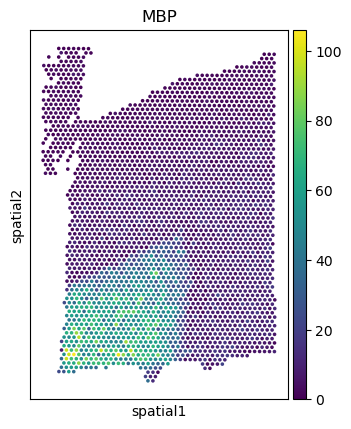

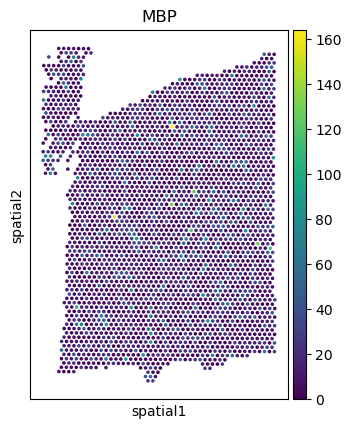

In [1]:
import scanpy as sc
simulated_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/simulation/data/free_151675_filtered.h5ad")
real_adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151675.h5ad")
sc.pl.spatial(real_adata,color = "MBP",spot_size=100)
sc.pl.spatial(simulated_adata,color = "MBP",spot_size=100)

In [10]:
real_adata.X

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 2., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 2., 0.]])